In [1]:
#dependencies
import json
import pandas as pd
import numpy as np 
import re

In [2]:
file_dir = '/Users/bkirton/desktop/dataAustin2020/Movies-ETL/resources/'

In [3]:
with open(f'{file_dir}wikipedia.movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [4]:
kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv')
ratings = pd.read_csv(f'{file_dir}ratings.csv')

In [5]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)

In [6]:
wiki_movies = [movie for movie in wiki_movies_raw 
                if ('Director' in movie or 'Directed by' in movie) 
                and 'imdb_link' in movie
                and 'No. of episodes' not in movie]
len(wiki_movies)

7076

In [7]:
def clean_movie(movie):
    #create a non destructive copy
    movie = dict(movie)
    alt_titles = {}
    #combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles)>0:
        movie['alt_titles'] = alt_titles
    #merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    #change column names 
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [8]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)

In [9]:
#regex string extraction for imdb links
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
wiki_movies_df.head()


7076
7033


,url,year,imdb_link,title,Based on,Starring,Narrated by,Cinematography,Release date,Running time,...,Created by,Preceded by,Suggested by,alt_titles,Recorded,Venue,Label,Animation by,Color process,imdb_id
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...","Andrew ""Dice"" Clay",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0098987
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",NaN,Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0098994
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",NaN,Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099005
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",NaN,Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099012
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",NaN,Russell Boyd,"December 19, 1990",95 minutes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tt0099018


In [10]:
#find number of null values in each column
[[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

[['url', 0],
 ['year', 0],
 ['imdb_link', 0],
 ['title', 1],
 ['Based on', 4852],
 ['Starring', 184],
 ['Narrated by', 6752],
 ['Cinematography', 691],
 ['Release date', 32],
 ['Running time', 139],
 ['Country', 236],
 ['Language', 244],
 ['Budget', 2295],
 ['Box office', 1548],
 ['Director', 0],
 ['Distributor', 357],
 ['Editor(s)', 548],
 ['Composer(s)', 518],
 ['Producer(s)', 202],
 ['Production company(s)', 1678],
 ['Writer(s)', 199],
 ['Genre', 6923],
 ['Original language(s)', 6875],
 ['Original network', 6908],
 ['Executive producer(s)', 6936],
 ['Production location(s)', 6986],
 ['Picture format', 6969],
 ['Audio format', 6972],
 ['Voices of', 7031],
 ['Followed by', 7024],
 ['Created by', 7023],
 ['Preceded by', 7023],
 ['Suggested by', 7032],
 ['alt_titles', 7012],
 ['Recorded', 7031],
 ['Venue', 7032],
 ['Label', 7031],
 ['Animation by', 7031],
 ['Color process', 7032],
 ['imdb_id', 0]]

In [11]:
#remove columns with null values greater than 10%
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [12]:
box_office = wiki_movies_df['Box office'].dropna()

In [13]:
#lambda function used to keep code clean 
box_office[box_office.map(lambda x: type(x) != str)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [14]:
box_office[box_office.map(lambda x: ' '.join(x) if type(x) == list else x)]

Box office
$21.4 million       NaN
$2.7 million        NaN
$57,718,089         NaN
$7,331,647          NaN
$6,939,946 (USA)    NaN
                   ... 
$19.4 million       NaN
$41.9 million       NaN
$76.1 million       NaN
$38.4 million       NaN
$5.5 million        NaN
Name: Box office, Length: 5485, dtype: object

In [15]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
box_office.str.contains(form_one, flags=re.IGNORECASE).sum()

3828

In [16]:
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'
box_office.str.contains(form_two, flags=re.IGNORECASE).sum()

1498

In [17]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE)

In [18]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [19]:
box_office.str.extract(f'({form_one}|{form_two})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7070,$19.4 million
7071,$41.9 million
7072,$76.1 million
7073,$38.4 million


In [20]:
def parse_dollars(s):
    # if s is not a string return NaN
    if type(s) != str:
        return np.nan
    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on',s,flags=re.IGNORECASE):
        # remove dollar sign and "million"
        s = re.sub('\$|\s|[a-zA-Z]','',s)
        # convert to float and multiply by a million
        value = float(s)*10**6
        # return value
        return value
    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on',s,flags=re.IGNORECASE):
        # remove dollar sign and "billion"
        s = re.sub('\$|\s|[a-zA-Z]','',s)
        # convert to float and multiply by a billion
        value = float(s)*10**9
        # return value
        return value
    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)',s,flags=re.IGNORECASE):
        # remove dollar sign and commas
        s = re.sub('\$|,','',s)
        # convert to float
        value = float(s)
        # return value
        return value
    # otherwise return NaN
    else:
        return np.nan

In [21]:
# extract values from box_office and apply parse_dollars
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
# drop box office column
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [22]:
# create budget variable
budget = wiki_movies_df['Budget'].dropna()

In [23]:
#convert any list to strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [24]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
budget[~matches_form_one & ~matches_form_two]

110                     $5–7 million
136                          Unknown
165                   $15-20 million
196     $6.5–10 million [1] [Note 1]
204      60 million Norwegian Kroner
                    ...             
7062                $100–150 million
7066                $160–200 million
7067                $102–135 million
7068                  $39–50 million
7070                    €4.3 million
Name: Budget, Length: 268, dtype: object

In [25]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

110                    $5–7 million
136                         Unknown
165                  $15-20 million
196        $6.5–10 million [Note 1]
204     60 million Norwegian Kroner
                   ...             
7062               $100–150 million
7066               $160–200 million
7067               $102–135 million
7068                 $39–50 million
7070                   €4.3 million
Name: Budget, Length: 268, dtype: object

In [26]:
# extract data from budget and apply parse dollars. drop budget column
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [27]:
# convert lists to strings for release date
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)


In [28]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [29]:
#extract dates
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)


,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7071,"December 25, 2018"
7072,"December 11, 2018"
7073,2018
7074,"August 31, 2018"


In [30]:
#convert to datetime using pandas
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)


In [31]:
#convert lists to strings
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)


In [32]:
#extract values with new pattern
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')


In [33]:
#convert strings to numeric values
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)


In [34]:
#save output to dataframe
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)


In [35]:
#drop running time column
wiki_movies_df.drop('Running time', axis=1, inplace=True)


In [36]:
#clean kaggle data
kaggle_metadata.dtypes


adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [37]:
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
Name: adult, dtype: int64

In [38]:
#drop adult column
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')



In [39]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [40]:
kaggle_metadata['video'] == 'True'
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'


In [41]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [42]:
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])


In [43]:
ratings.info(null_counts=True)
pd.to_datetime(ratings['timestamp'], unit='s')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [44]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')


count    2.602429e+07
mean     3.528090e+00
std      1.065443e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

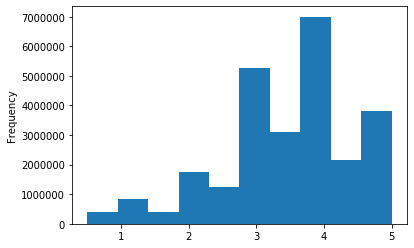

In [45]:
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

In [46]:
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki', '_kaggle'])

In [47]:
# Competing data:
# Wiki                     Movielens                Resolution
#--------------------------------------------------------------------------
# title_wiki               title_kaggle             drop wikipedia
# running_time             runtime                  keep kaggle, wiki = 0
# budget_wiki              budget_kaggle            keep kaggle, wiki = 0
# box_office               revenue                  keep kaggle, wiki = 0
# release_date_wiki        release_date_kaggle      drop wikipedia
# Language                 original_language        drop wikipedia
# Production company(s)    production_companies     drop wikipedia

In [48]:
movies_df.drop(columns=['title_wiki', 'release_date_wiki', 'Language','Production company(s)'], inplace=True)

In [49]:
#function that fills in missing data for a column pair and drops redundant column
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column], axis=1
    )
    df.drop(columns= wiki_column, inplace=True)

In [50]:
#use function for 3 columns we decided to set to 0 (running_time, budget_wiki, box_office)
fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')


In [51]:
#double check that no columns contain only 1 value, convert lists to tuples for value_counts() to work
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

video


In [52]:
movies_df['video'].value_counts(dropna=False)

False    6052
Name: video, dtype: int64

In [53]:
#reorder columns for ease of reading 
movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
                      ]]

In [54]:
movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

In [55]:
#include raw ratings data and rename userId to count and pivot data so that movieId becomes the index
rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId', columns='rating', values='count')

In [56]:
# rename columns for ease of understanding. prepend 'rating_' to each column
rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]

In [57]:
#left merge to keep all data in movies_df
movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')

In [58]:
#deal with missing values
movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)